In [1]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available.")
else:
    print("MPS backend is not available.")

MPS backend is available.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)  
    return pd.DataFrame(data)

df = load_data('../fast_russian_embeddings.json')

In [3]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
X = np.array(df['embedding'].tolist(), dtype=np.float32) 
y = df['label_encoded'].values

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
EMBEDDING_DIM = 312
NUM_CLASSES = 3
BATCH_SIZE =64

train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.int32)
    )
val_dataset = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.int32)
    )
test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.int32)
    )

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train 
)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
class_weights = torch.tensor(np.log(class_weights + 1) * 0.5, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [7]:
class BiLSTM_CNN(nn.Module):
    def __init__(self, 
                 embedding_dim=312,
                 hidden_dim=512,  
                 num_classes=3,
                 n_filters=100,
                 filter_sizes=[1, 3, 5],
                 dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 
        )
        
        self.convs = nn.ModuleList([
            nn.Conv1d(
                2 * hidden_dim, 
                n_filters, 
                kernel_size=fs,
                padding=(fs - 1) // 2  # Паддинг для сохранения размера
            ) 
            for fs in filter_sizes
        ])
        
        self.bn = nn.BatchNorm1d(len(filter_sizes) * n_filters)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(0, 2, 1)  # (batch, channels, seq_len)
        
        pooled = []
        for conv in self.convs:
            conv_out = F.relu(conv(lstm_out))
            pooled_out = F.max_pool1d(conv_out, conv_out.size(2))
            pooled.append(pooled_out)
            
        cat = self.bn(torch.cat(pooled, dim=1).squeeze(2))
        return self.fc(self.dropout(cat))

In [8]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in iterator:
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(predictions, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        epoch_loss += loss.item()
        
    acc = correct / total
    return epoch_loss / len(iterator), acc

In [9]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            predictions = model(x)
            loss = criterion(predictions, y)
            epoch_loss += loss.item()
            
            _, preds = torch.max(predictions, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    return epoch_loss / len(iterator), acc

In [10]:
model = BiLSTM_CNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=256,
    num_classes=NUM_CLASSES,
    n_filters=100,
    filter_sizes=[3,5,7],
    dropout=0.1
)
model = model.to(device)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [28]:
# optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-4)

optimizer = optim.SGD(
    model.parameters(), 
    lr=0.001, 
    momentum=0.9, 
    nesterov=True, 
    weight_decay=1e-4
)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.1, 
#     patience=1
# )
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer, 
    base_lr=0.00001, 
    max_lr=0.1, 
    step_size_up=2000

)

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [31]:
early_stopping = EarlyStopping(patience=5)
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    scheduler.step(valid_loss)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
   
    if valid_loss == early_stopping.best_loss:
        torch.save(model.state_dict(), 'best_model.pth')
    

    print(f"Epoch {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {valid_loss:.4f} Acc: {valid_acc*100:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01
	Train Loss: 0.7700 Acc: 70.62%
	Val Loss: 0.7787 Acc: 72.62%
Epoch 02
	Train Loss: 0.7700 Acc: 70.65%
	Val Loss: 0.7723 Acc: 71.61%
Epoch 03
	Train Loss: 0.7707 Acc: 70.57%
	Val Loss: 0.7730 Acc: 71.51%
Epoch 04
	Train Loss: 0.7696 Acc: 70.70%
	Val Loss: 0.7719 Acc: 69.28%
Epoch 05
	Train Loss: 0.7716 Acc: 70.70%
	Val Loss: 0.7725 Acc: 68.34%
Epoch 06
	Train Loss: 0.7711 Acc: 70.70%
	Val Loss: 0.7697 Acc: 70.88%
Epoch 07
	Train Loss: 0.7720 Acc: 70.61%
	Val Loss: 0.7727 Acc: 71.21%
Epoch 08
	Train Loss: 0.7707 Acc: 70.66%
	Val Loss: 0.7692 Acc: 69.89%
Epoch 09
	Train Loss: 0.7696 Acc: 70.71%
	Val Loss: 0.7690 Acc: 70.26%
Epoch 10
	Train Loss: 0.7694 Acc: 70.83%
	Val Loss: 0.7723 Acc: 71.46%
Epoch 11
	Train Loss: 0.7701 Acc: 70.63%
	Val Loss: 0.7721 Acc: 69.16%
Epoch 12
	Train Loss: 0.7728 Acc: 70.78%
	Val Loss: 0.7708 Acc: 71.05%
Epoch 13
	Train Loss: 0.7723 Acc: 70.86%
	Val Loss: 0.7715 Acc: 71.41%
Early stopping triggered


Test Loss: 0.7661
Accuracy: 70.27%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.52      0.72      0.61      2921
     Neutral       0.38      0.40      0.39      3780
    Positive       0.87      0.79      0.83     13050

    accuracy                           0.70     19751
   macro avg       0.59      0.64      0.61     19751
weighted avg       0.73      0.70      0.71     19751



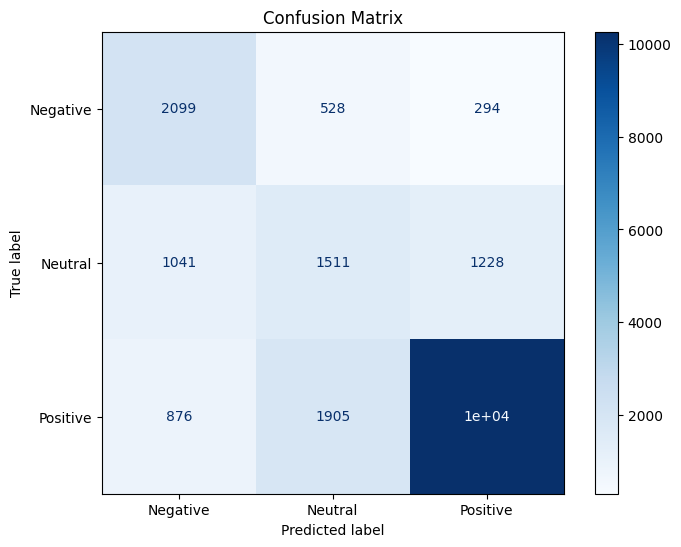

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device).float()
            y = y.to(device).long()
            
            
            if x.dim() == 2:
                x = x.unsqueeze(1)
                
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    
    test_loss /= len(test_loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_loss, accuracy


class_names = ['Negative', 'Neutral', 'Positive']  
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

test_loss, test_acc = evaluate_model(model, test_loader, device, class_names)